In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from pathlib import Path
from config_paths import DATASET_PATH, OPTIMIZATION_PATH
from lxml import etree

sns.set(style="whitegrid")
pio.renderers.default = "vscode"


In [2]:
def prepare_data():
    csv_files = list(OPTIMIZATION_PATH.rglob("*df_reduced.csv"))
    dataframes = []

    for file in csv_files:
        df = pd.read_csv(file)
        parts = file.parts[-6:]
        
        match_id = parts[0]
        step = parts[2]
        method = parts[3]
        parameters = parts[4]

        df["game_id"] = match_id
        df["step"] = step
        df["method"] = method
        df["parameters"] = parameters
        df["tuning"] = method + "-" + parameters

        dataframes.append(df)

    full_df = pd.concat(dataframes, ignore_index=True)
    full_df["DAS_potential_percentage"] = np.where(
        full_df["DAS_potential"] > 0,
        ((full_df["DAS"] - full_df["DAS_new"]) / full_df["DAS"]) * 100,
        0.0,
    )
    full_df = full_df.reindex(["step", "game_id", "player_id", "method", "parameters", "tuning", "frame", "new_frame", "DAS", "DAS_new", "DAS_potential", "DAS_potential_percentage", "move_x", "move_y", "distance"], axis=1)
    df_merger = pd.read_csv("output/df_log_merger.csv", )
    full_df = full_df.merge(df_merger, how="left", on=["step", "game_id", "player_id", "method", "parameters"])
    return full_df

def group_data(full_df):

    grouped_df = (
        full_df.groupby(["step", "game_id", "player_id", "method", "parameters", "tuning"]).agg(
            MEAN_DAS_potential=("DAS_potential", "mean"),
            MAX_DAS_potential=("DAS_potential", "max"),
            MEDIAN_DAS_potential=("DAS_potential", "median"),
            SUMME_DAS_potential=("DAS_potential", "sum"),
            SUMME_DAS_original=("DAS", "sum"),
            SUMME_DAS_new=("DAS_new", "sum"),
            STD_DAS_potential=("DAS_potential", "std"),
            IQR_DAS_potential=("DAS_potential", lambda x: x.quantile(0.75) - x.quantile(0.25)),
            Q10_DAS_potential=("DAS_potential", lambda x: x.quantile(0.10)),
            Q90_DAS_potential=("DAS_potential", lambda x: x.quantile(0.90)),

            MEAN_DAS_potential_percentage=("DAS_potential_percentage", "mean"),
            MEDIAN_DAS_potential_percentage=("DAS_potential_percentage", "median"),
            SUMME_DAS_potential_percentage=("DAS_potential_percentage", "sum"),
            STD_DAS_potential_percentage=("DAS_potential_percentage", "std"),
            IQR_DAS_potential_percentage=("DAS_potential_percentage", lambda x: x.quantile(0.75) - x.quantile(0.25)),

            distance=("distance", "mean"),
            count=("DAS_potential", "count"),
            time=("time_sec", "first")
        )
        .reset_index()
    )
    return grouped_df

def add_player_names():
    files = list(DATASET_PATH.rglob("*players.parquet"))
    dataframes = []
    
    for file in files:
        df = pd.read_parquet(file).copy()
        
        parts = file.parts
        game_id = parts[9]
        df["game_id"] = game_id
        df["team"] = "home" if "home_players" in parts[10] else "away"
        df["player"] = df['team'] + "_" + df['shirt_num'].astype(str)
        dataframes.append(df)
    
    all_players = pd.concat(dataframes, ignore_index=True)
    cols = ["game_id", "id", "full_name", "player"]
    return all_players[cols].drop_duplicates()

def line_players(grouped_df, metric="DAS_potential"):
    df = grouped_df.copy()
    df["game_id"] = df["game_id"].astype(str)
    tunings = df["tuning"].unique()
    
    fig = go.Figure()
    trace_tuning = []
    
    hovertemplate = (
        "Spiel: %{x}<br>"
        f"{metric}: " + "%{y:.3f}<br>"
        "count: %{customdata}<extra></extra>"
    )
    
    for t in tunings:
        dft = df[df["tuning"] == t]
        for name, g in dft.groupby("full_name"):
            fig.add_trace(
                go.Scatter(
                    x=g["game_id"], y=g[metric],
                    mode="lines+markers",
                    name=name,
                    legendgroup=name,
                    showlegend=(t == tunings[0]),
                    customdata=g["count"].values,
                    hovertemplate=hovertemplate,
                    marker=dict(size=6),
                    line=dict(width=1)
                )
            )
            trace_tuning.append(t)
            
    buttons = []
    for t in tunings:
        visible_mask = [tt == t for tt in trace_tuning]
        buttons.append(dict(
            label=t,
            method="update",
            args=[
                {"visible": visible_mask},
                {"title": f"DAS Potential pro Spiel (Tuning: {t})"}
            ]
        ))
    initial_mask = [tt == tunings[0] for tt in trace_tuning]
    fig.update_traces(visible=False)
    for i, vis in enumerate(initial_mask):
        fig.data[i].visible = vis
        
    # fig = px.line(
    #     grouped_df,
    #     x="game_id",
    #     y="DAS_potential",
    #     color="full_name",
    #     markers=True,
    #     title="DAS Potential pro Spiel"
    # )

    
    fig.update_layout(
        title=f"DAS Potential pro Spiel (Tuning: {tunings[0]})",
        xaxis_title="Spiel",
        yaxis_title=metric,
        legend_title="Spieler",
        updatemenus=[dict(
            type="dropdown",
            x=1.1,
            y=1.15,
            xanchor="left",
            buttons=buttons,
            active=0
        )],
        hovermode="closest"
    )
    fig.show()
    
def facet_grid(grouped_df):
    g = sns.FacetGrid(
        data=grouped_df,
        col="game_id",
        hue="method",
        sharey=True,
        height=4,
        aspect=1.5
    )
    g.map(sns.barplot, "player", "DAS_potential_percentage", order=sorted(grouped_df["player"].unique()), errorbar=None)
    g.add_legend()
    g.set_titles(col_template="Match: {col_name}")
    g.set_axis_labels("Spieler", "Verbesserung (%)")
    for ax in g.axes.flat:
        ax.tick_params(axis="x", rotation=45)
        
    plt.tight_layout()
    plt.show()

def extract_player_positions():
    data = []
    for file in DATASET_PATH.rglob("metadata.xml"):
        tree = etree.parse(str(file))
        root = tree.getroot()
        for player in root.findall(".//Players/Player"):
            team = player.getparent().getparent()
            data.append({
                "game_id": file.parts[-2],
                "id": player.get("PersonId"),
                "position": player.get("PlayingPosition"),
                "starting": player.get("Starting"),
                "team": team.get("TeamName")
            })
        
    return pd.DataFrame(data)
        
    
    
    
# Full Data: (step, game_id, player_id, method, parameters, tuning, frame, new_frame, DAS, DAS_new, DAS_potential, DAS_potential_percentage, move_x, move_Y, distance) -> Eine Zeile für jeden berechneten Frame
full_df = prepare_data()
full_df.to_csv("output/full_das.csv", index=False)

# Grouped Data: (step, game_id, player_id, method, parameters, tuning, MEAN_DAS_potential, MAX_DAS_potential, MEDIAN_DAS_potential, MEAN_DAS_potential_percentage, distance, count) -> Eine Zeile pro (step, game, player, method, parameters)
grouped_df = group_data(full_df)
grouped_df.to_csv("output/grouped_das.csv", index=False)

display(full_df.shape)
display(full_df)
display(grouped_df.shape)
display(grouped_df)
    

(83552, 16)

,step,game_id,player_id,method,parameters,tuning,frame,new_frame,DAS,DAS_new,DAS_potential,DAS_potential_percentage,move_x,move_y,distance,time_sec
0,step125,J03WOH,home_19,grid_search_cut_0.1,R_5-S_1.5-D_2-N_5-C_0.1,grid_search_cut_0.1-R_5-S_1.5-D_2-N_5-C_0.1,160412,160412_home_19_0.262500_-0.26,0.244021,0.226647,0.017374,7.120028,0.2625,-0.26,0.369468,17.4407
1,step125,J03WOH,home_19,grid_search_cut_0.1,R_5-S_1.5-D_2-N_5-C_0.1,grid_search_cut_0.1-R_5-S_1.5-D_2-N_5-C_0.1,160728,160728_home_19_-0.525000_0.52,0.591525,0.585404,0.006121,1.034811,-0.5250,0.52,0.738935,17.4407
2,step125,J03WOH,home_19,grid_search_cut_0.1,R_5-S_1.5-D_2-N_5-C_0.1,grid_search_cut_0.1-R_5-S_1.5-D_2-N_5-C_0.1,160887,160887_home_19_-1.050000_0.00,1.964608,1.900816,0.063792,3.247053,-1.0500,0.00,1.050000,17.4407
3,step125,J03WOH,home_19,grid_search_cut_0.1,R_5-S_1.5-D_2-N_5-C_0.1,grid_search_cut_0.1-R_5-S_1.5-D_2-N_5-C_0.1,164747,164747_home_19_-1.050000_0.00,0.140323,0.138158,0.002165,1.542877,-1.0500,0.00,1.050000,17.4407
4,step125,J03WOH,home_19,all_positions_cut_1.0,R_5-S_1.5-D_2-N_20-C_1.0,all_positions_cut_1.0-R_5-S_1.5-D_2-N_20-C_1.0,160887,160887_home_19_-3.50_2.50,1.964608,1.913872,0.050736,2.582484,-3.5000,2.50,4.301163,1.4696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83547,step125,J03WN1,home_31,all_positions_cut_0.1,R_5-S_1-D_2-N_20-C_0.1,all_positions_cut_0.1-R_5-S_1-D_2-N_20-C_0.1,155532,155532_home_31_0.00_-5.00,3.132049,2.952712,0.179336,5.725851,0.0000,-5.00,5.000000,123.9913
83548,step125,J03WN1,home_31,all_positions_cut_0.1,R_5-S_1-D_2-N_20-C_0.1,all_positions_cut_0.1-R_5-S_1-D_2-N_20-C_0.1,158123,158123_home_31_-2.00_-4.00,2.387345,2.065800,0.321545,13.468713,-2.0000,-4.00,4.472136,123.9913
83549,step125,J03WN1,home_31,all_positions_cut_0.1,R_5-S_1-D_2-N_20-C_0.1,all_positions_cut_0.1-R_5-S_1-D_2-N_20-C_0.1,166506,166506_home_31_5.00_0.00,0.246944,0.241352,0.005592,2.264450,5.0000,0.00,5.000000,123.9913
83550,step125,J03WN1,home_31,all_positions_cut_0.1,R_5-S_1-D_2-N_20-C_0.1,all_positions_cut_0.1-R_5-S_1-D_2-N_20-C_0.1,168445,168445_home_31_0.00_-5.00,0.367376,0.363733,0.003643,0.991750,0.0000,-5.00,5.000000,123.9913


(1376, 24)

,step,game_id,player_id,method,parameters,tuning,MEAN_DAS_potential,MAX_DAS_potential,MEDIAN_DAS_potential,SUMME_DAS_potential,...,Q10_DAS_potential,Q90_DAS_potential,MEAN_DAS_potential_percentage,MEDIAN_DAS_potential_percentage,SUMME_DAS_potential_percentage,STD_DAS_potential_percentage,IQR_DAS_potential_percentage,distance,count,time
0,step1000,J03WQQ,home_25,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,0.247786,3.354120,0.007908,5.451283,...,0.000929,0.327250,7.481954,6.748946,164.602990,7.011208,8.871858,4.332142,22,33.8422
1,step1000,J03WQQ,home_25,random,R_5-S_1-D_2-N_5,random-R_5-S_1-D_2-N_5,0.236460,4.087379,0.003842,5.202120,...,0.000000,0.167767,5.307764,2.861809,116.770810,7.882187,7.084575,3.696520,22,12.2141
2,step125,J03WMX,away_10,all_positions_cut_0.1,R_5-S_1-D_2-N_20-C_0.1,all_positions_cut_0.1-R_5-S_1-D_2-N_20-C_0.1,0.097703,1.622119,0.013450,8.890979,...,0.000779,0.289272,4.765651,1.821515,433.674203,7.322979,6.360389,4.541589,91,588.5924
3,step125,J03WMX,away_11,all_positions_cut_0.1,R_5-S_1-D_2-N_20-C_0.1,all_positions_cut_0.1-R_5-S_1-D_2-N_20-C_0.1,0.218963,4.439813,0.019864,16.641198,...,0.000350,0.513490,6.356891,2.380693,483.123716,9.144009,6.521861,4.619352,76,376.1916
4,step125,J03WMX,away_13,all_positions_cut_0.1,R_5-S_1-D_2-N_20-C_0.1,all_positions_cut_0.1-R_5-S_1-D_2-N_20-C_0.1,0.013686,0.053486,0.010342,0.205294,...,0.000412,0.032375,1.902828,0.506414,28.542423,2.948037,1.726979,5.000000,15,68.3045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1371,step125,J03WR9,home_9,random_cut_0.75,R_5-S_1-D_2-N_20-C_0.75,random_cut_0.75-R_5-S_1-D_2-N_20-C_0.75,0.287767,5.105295,0.007141,6.906410,...,0.000461,0.258217,1.478837,0.190905,35.492093,2.922792,1.464116,4.485513,24,32.3412
1372,step125,J03WR9,home_9,random_cut_0.75,R_5-S_1-D_2-N_50-C_0.75,random_cut_0.75-R_5-S_1-D_2-N_50-C_0.75,0.301515,5.105295,0.014679,7.236362,...,0.001400,0.273377,1.688283,0.303756,40.518792,2.965986,1.487851,4.846798,24,74.7253
1373,step125,J03WR9,home_9,random_cut_1.0,R_5-S_1-D_2-N_20-C_1.0,random_cut_1.0-R_5-S_1-D_2-N_20-C_1.0,0.239080,3.446676,0.010911,5.498838,...,0.001147,0.278323,1.392180,0.298639,32.020135,2.173319,1.377722,4.657388,23,29.6389
1374,step125,J03WR9,home_9,random_cut_1.0,R_5-S_1-D_2-N_50-C_1.0,random_cut_1.0-R_5-S_1-D_2-N_50-C_1.0,0.315034,5.105295,0.015549,7.245784,...,0.001493,0.285523,1.767867,0.434682,40.660937,3.010713,1.662222,4.722610,23,72.0313


In [26]:
# Wenn unterwegs keine Festplatte
full_df = pd.read_csv("output/full_das.csv")
grouped_df = pd.read_csv("output/grouped_das.csv")

In [3]:
# Übersicht Anzahl vorhandene Kombinationen pro Spiel => Step 125
df_overview = full_df.copy()
df_overview = df_overview[df_overview["step"] == "step125"]
df_overview["cut"] = df_overview["method"].apply(lambda x: x.split("cut_")[-1] if "cut" in x else "-")
df_overview["method"] = df_overview["method"].apply(lambda x: x.split("_cut")[0])
df_overview["n"] = df_overview["parameters"].apply(lambda x: x.split("N_")[1].split("-")[0])
df_overview["step_size"] = df_overview["parameters"].apply(lambda x: x.split("S_")[1].split("-")[0])
# display(df_overview)

pivot = df_overview.groupby(["game_id", "method", "cut", "n", "step_size"])["player_id"].nunique().unstack(["method", "cut", "n", "step_size"], fill_value=0).reset_index()
pivot_ids = (df_overview.groupby(["game_id","method","cut","n","step_size"])["player_id"]
             .apply(lambda s: tuple(sorted(set(s))))
             .unstack(["method","cut","n","step_size"]))

pivot = (pivot
    .set_index("game_id")                               
    .sort_index(axis=1, level=[0,1,2], sort_remaining=False)
    .reset_index()                                          
)

pivot_focus = pivot[[
    ('game_id', '', '', ''),
    ('all_positions', '-', '20', '1'),
    ('all_positions', '0.1', '20', '1'),
    ('all_positions', '0.25', '20', '1'),
    ('grid_search', '-', '5', '1.5'),
    ('grid_search', '0.1', '5', '1.5'),
    ('grid_search', '0.25', '5', '1.5')
]]

display(pivot.style.format(precision=0))

display(pivot_focus.style.format(precision=0))

ids = pivot_ids.loc["J03WR9", ("grid_search", "-", "5", "1.5")]
# display(ids)
# ids = pivot_ids.loc["J03WQQ", ("grid_search", "-", "5", "1.5")]
# display(ids)


In [4]:
# Relevanten Frame für Spielerliste speichern
df_player_list = full_df[
    (full_df["step"] == "step125") &
    (full_df["method"] == "all_positions_cut_0.1")
].copy()
n_total_games = df_player_list["game_id"].nunique()
all_players = add_player_names()
player_positions = extract_player_positions()
df_player_list = df_player_list.merge(all_players, left_on=["game_id", "player_id"], right_on=["game_id", "player"])
df_player_list = df_player_list.merge(player_positions, on=["game_id", "id"])


df_player_list.to_csv("output/df_player_list.csv", index=False)

# display(df_player_list)
# display(all_players)
# display(player_positions)

## Vergleiche über alle Methoden

'Vergleich ohne CUT'

'Anzahl verschiedener Parameterkombinationen: 5'

'Vollständige Kombinationen: 40'

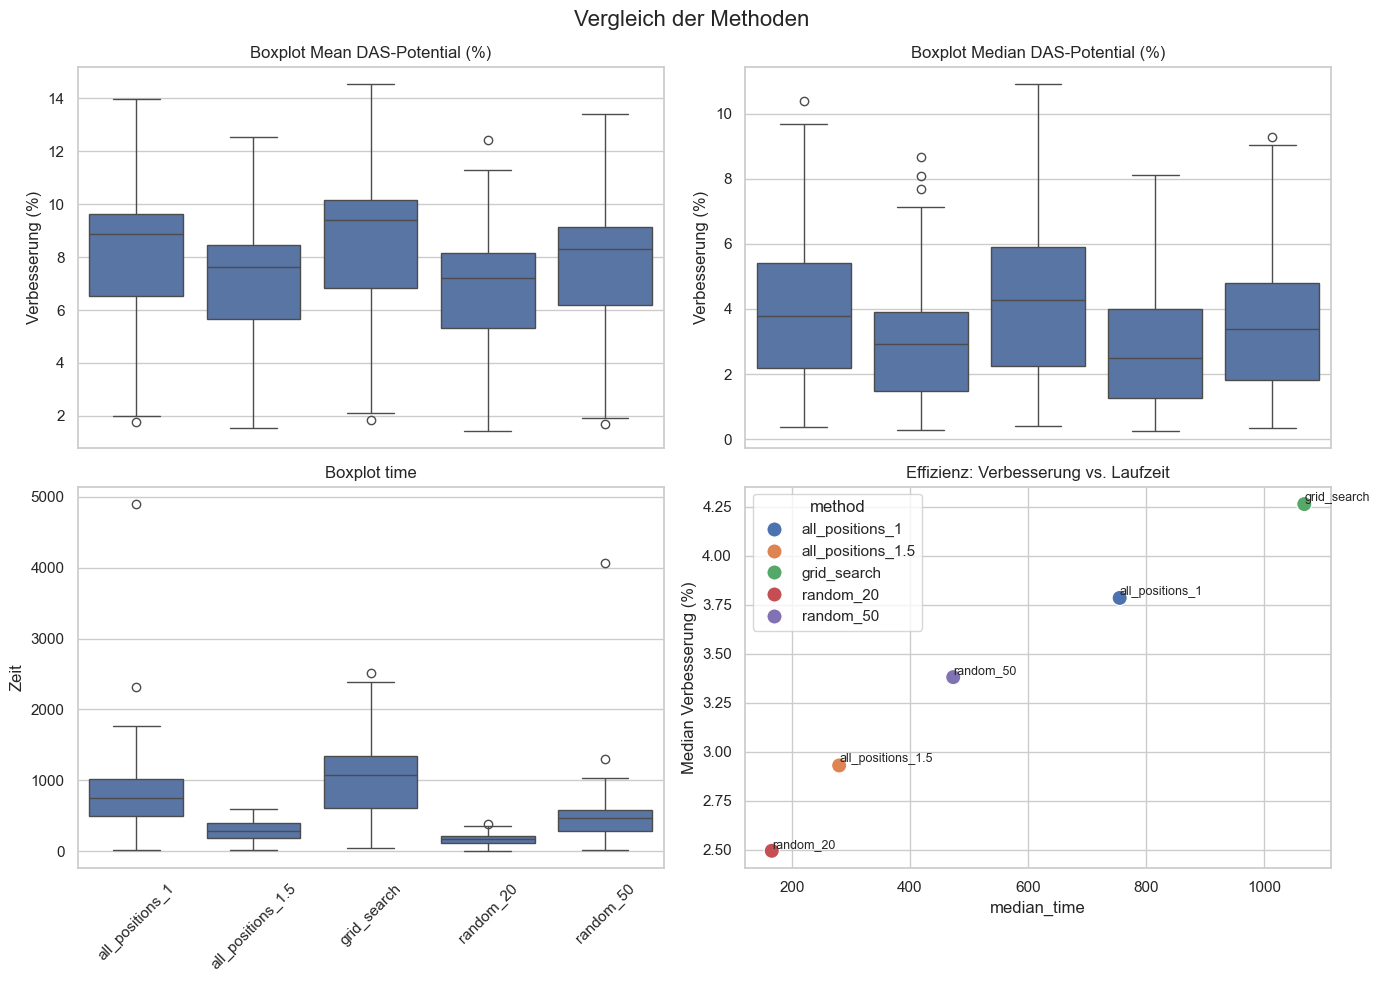

In [5]:
# Fairer Vergleich Methoden / Parameter STEP 125 => (N20, N50, ALLP, Grid)
def compare_methods(fair_grouped_df, df_agg_scatter=None, x_axis="method"):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    sns.boxplot(data=fair_grouped_df,
                x=x_axis,
                y="MEAN_DAS_potential_percentage",
                ax=axes[0, 0]
    )
    axes[0, 0].set_title("Boxplot Mean DAS-Potential (%)")
    axes[0, 0].set_ylabel("Verbesserung (%)")
    axes[0, 0].set_xlabel("")
    axes[0, 0].tick_params(axis="x", which="both", bottom=False, labelbottom=False)
    
    sns.boxplot(data=fair_grouped_df,
                x=x_axis,
                y="MEDIAN_DAS_potential_percentage",
                ax=axes[0, 1]
    )
    axes[0, 1].set_title("Boxplot Median DAS-Potential (%)")
    axes[0, 1].set_ylabel("Verbesserung (%)")
    axes[0, 1].set_xlabel("")
    axes[0, 1].tick_params(axis="x", which="both", bottom=False, labelbottom=False)


    sns.boxplot(data=fair_grouped_df,
                x=x_axis,
                y="time",
                ax=axes[1, 0]
    )
    axes[1, 0].set_title("Boxplot time")
    axes[1, 0].set_ylabel("Zeit")
    axes[1, 0].set_xlabel("")
    axes[1, 0].tick_params(axis="x", rotation=45)
    
    if df_agg_scatter is not None:
        sns.scatterplot(
            data=df_agg_scatter,
            x="median_time",
            y="median_improvement_pct",
            hue="method",
            s=120,
            ax=axes[1, 1]
        )
        for _, row in df_agg_scatter.iterrows():
            axes[1, 1].text(
                row["median_time"],
                row["median_improvement_pct"],
                row["method"],
                ha="left",
                va="bottom",
                fontsize=9
            )

        # axes[2, 1].set_xlabel("Median-Laufzeit pro Frame")
        axes[1, 1].set_ylabel("Median Verbesserung (%)")
        axes[1, 1].set_title("Effizienz: Verbesserung vs. Laufzeit")
        
        
    else:
        axes[1, 1].axis("off")
    
    fig.suptitle("Vergleich der Methoden", fontsize=16)
    fig.tight_layout()
    plt.show()

grouped_df_125 = grouped_df[grouped_df["step"] == "step125"].copy()
grouped_df_125["cut"] = grouped_df_125["method"].apply(lambda x: x.split("cut_")[-1] if "cut" in x else "-")
# grouped_df_125["method"] = grouped_df_125["method"].apply(lambda x: x.split("_cut")[0])
grouped_df_125["n"] = grouped_df_125["parameters"].apply(lambda x: x.split("N_")[1].split("-")[0])
grouped_df_125["s"] = grouped_df_125["parameters"].apply(lambda x: x.split("S_")[1].split("-")[0])
mask_random = grouped_df_125["method"].str.contains("random")
grouped_df_125["method"] = np.where(
    mask_random,
    grouped_df_125["method"] + "_" + grouped_df_125["n"].astype(pd.Int64Dtype()).astype(str),
    grouped_df_125["method"],
)
mask_all_positions = grouped_df_125["method"].str.contains("all_positions")
grouped_df_125["method"] = np.where(
    mask_all_positions,
    grouped_df_125["method"] + "_" + grouped_df_125["s"].astype(str),
    grouped_df_125["method"]
)

# Vergleich Methoden/Parameter ohne CUT => (R20, R50, ALLP, Grid)
df_ohne_cut = grouped_df_125[grouped_df_125["cut"] == "-"].copy()
n_total_params_ohne_cut = df_ohne_cut["tuning"].nunique()
display("Vergleich ohne CUT")
display(f"Anzahl verschiedener Parameterkombinationen: {n_total_params_ohne_cut}")
param_counts_ohne_cut = (
    df_ohne_cut.groupby(["game_id", "player_id"])["tuning"]
    .nunique()
    .reset_index(name="param_count")
)
complete_combinations_ohne_cut = param_counts_ohne_cut[param_counts_ohne_cut["param_count"] == n_total_params_ohne_cut]
display(f"Vollständige Kombinationen: {len(complete_combinations_ohne_cut)}")

fair_grouped_df_ohne_cut = df_ohne_cut.merge(complete_combinations_ohne_cut, on=["game_id", "player_id"])
fair_grouped_df_ohne_cut["method"] = fair_grouped_df_ohne_cut["method"].apply(lambda x: x.split("_cut")[0])
# display(fair_grouped_df_ohne_cut)
df_agg_scatter_ohne_cut = (
    fair_grouped_df_ohne_cut.groupby("method").agg(
        median_improvement_pct=("MEDIAN_DAS_potential_percentage", "median"),
        median_time=("time", "median")
    )
    .reset_index()
)

compare_methods(fair_grouped_df_ohne_cut, df_agg_scatter_ohne_cut)

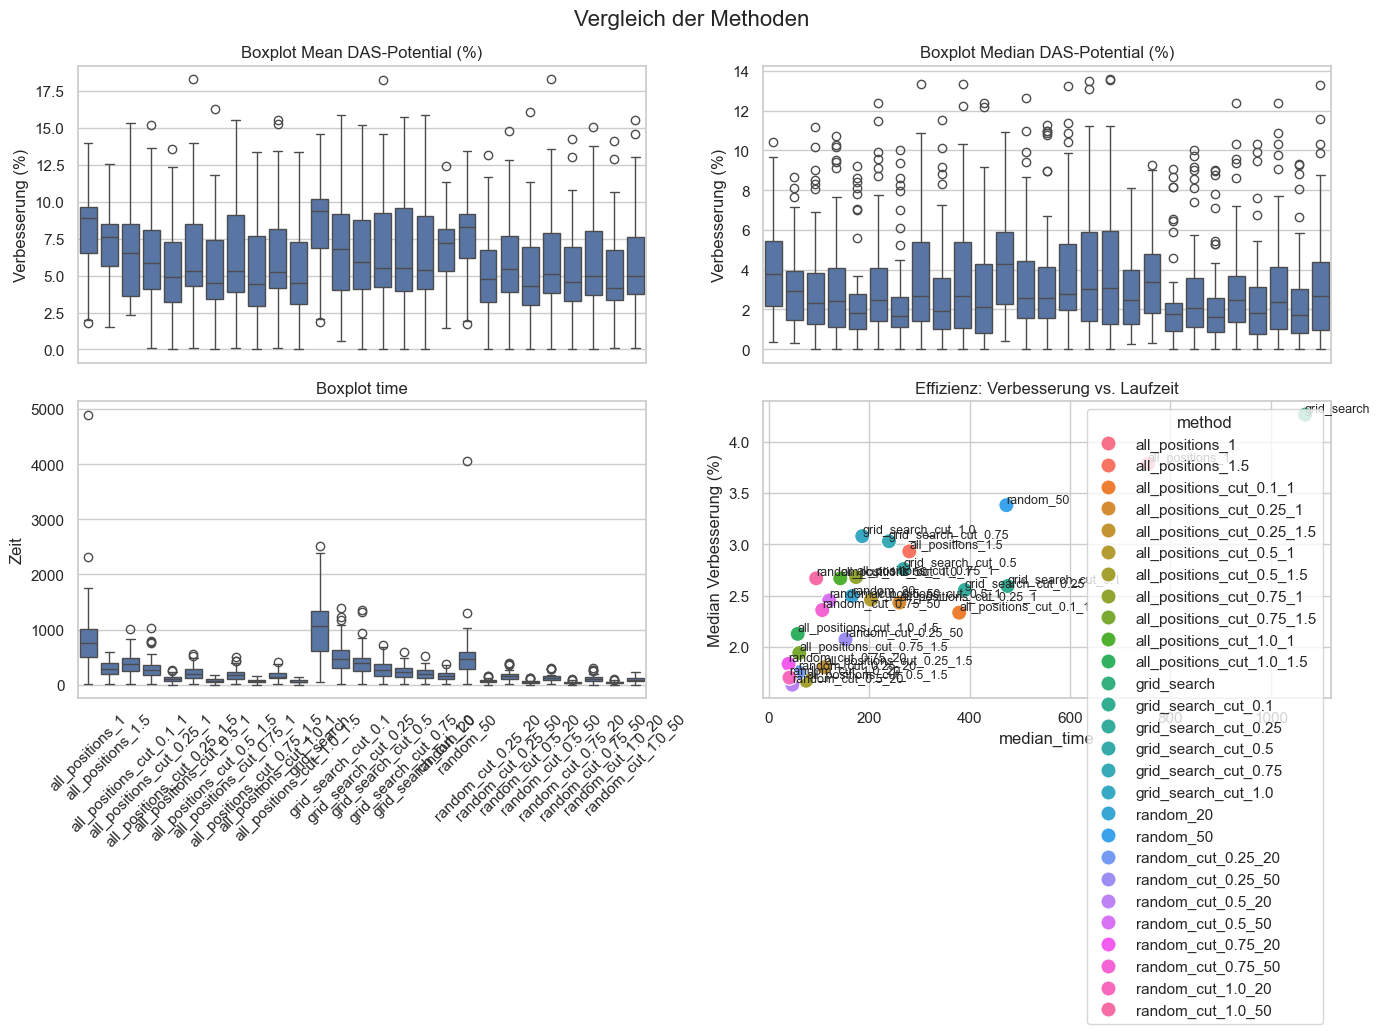

,step,game_id,player_id,method,parameters,tuning,MEAN_DAS_potential,MAX_DAS_potential,MEDIAN_DAS_potential,SUMME_DAS_potential,...,MEDIAN_DAS_potential_percentage,SUMME_DAS_potential_percentage,STD_DAS_potential_percentage,IQR_DAS_potential_percentage,distance,count,time,cut,n,s
2,step125,J03WMX,away_10,all_positions_cut_0.1_1,R_5-S_1-D_2-N_20-C_0.1,all_positions_cut_0.1-R_5-S_1-D_2-N_20-C_0.1,0.097703,1.622119,0.013450,8.890979,...,1.821515,433.674203,7.322979,6.360389,4.541589,91,588.5924,0.1,20,1
3,step125,J03WMX,away_11,all_positions_cut_0.1_1,R_5-S_1-D_2-N_20-C_0.1,all_positions_cut_0.1-R_5-S_1-D_2-N_20-C_0.1,0.218963,4.439813,0.019864,16.641198,...,2.380693,483.123716,9.144009,6.521861,4.619352,76,376.1916,0.1,20,1
4,step125,J03WMX,away_13,all_positions_cut_0.1_1,R_5-S_1-D_2-N_20-C_0.1,all_positions_cut_0.1-R_5-S_1-D_2-N_20-C_0.1,0.013686,0.053486,0.010342,0.205294,...,0.506414,28.542423,2.948037,1.726979,5.000000,15,68.3045,0.1,20,1
5,step125,J03WMX,away_2,all_positions_cut_0.1_1,R_5-S_1-D_2-N_20-C_0.1,all_positions_cut_0.1-R_5-S_1-D_2-N_20-C_0.1,0.273963,2.059126,0.084604,24.930619,...,8.422998,1165.805713,13.751628,9.700098,4.475998,91,573.4757,0.1,20,1
6,step125,J03WMX,away_22,all_positions_cut_0.1_1,R_5-S_1-D_2-N_20-C_0.1,all_positions_cut_0.1-R_5-S_1-D_2-N_20-C_0.1,0.333604,3.749202,0.047964,10.008124,...,4.800939,214.125865,8.227441,7.379629,4.820573,30,155.8418,0.1,20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1370,step125,J03WR9,home_9,random_cut_0.5_50,R_5-S_1-D_2-N_50-C_0.5,random_cut_0.5-R_5-S_1-D_2-N_50-C_0.5,0.272113,5.105295,0.008777,7.347055,...,0.434682,42.986341,2.823958,1.141649,4.798247,27,85.4522,0.5,50,1
1371,step125,J03WR9,home_9,random_cut_0.75_20,R_5-S_1-D_2-N_20-C_0.75,random_cut_0.75-R_5-S_1-D_2-N_20-C_0.75,0.287767,5.105295,0.007141,6.906410,...,0.190905,35.492093,2.922792,1.464116,4.485513,24,32.3412,0.75,20,1
1372,step125,J03WR9,home_9,random_cut_0.75_50,R_5-S_1-D_2-N_50-C_0.75,random_cut_0.75-R_5-S_1-D_2-N_50-C_0.75,0.301515,5.105295,0.014679,7.236362,...,0.303756,40.518792,2.965986,1.487851,4.846798,24,74.7253,0.75,50,1
1373,step125,J03WR9,home_9,random_cut_1.0_20,R_5-S_1-D_2-N_20-C_1.0,random_cut_1.0-R_5-S_1-D_2-N_20-C_1.0,0.239080,3.446676,0.010911,5.498838,...,0.298639,32.020135,2.173319,1.377722,4.657388,23,29.6389,1.0,20,1


In [6]:
# Fairer Vergleich Methoden / Parameter STEP 125 mit CUT 
df_mit_cut = grouped_df_125.copy()
n_total_params = df_mit_cut["tuning"].nunique()
param_counts =(
    df_mit_cut.groupby(["game_id", "player_id"])["tuning"]
    .nunique()
    .reset_index(name="param_count")
)
complete_combinations = param_counts[param_counts["param_count"] == n_total_params]

fair_grouped_df = df_mit_cut.merge(complete_combinations, on=["game_id", "player_id"])

df_agg_scatter = (
    fair_grouped_df.groupby("method").agg(
        median_improvement_pct=("MEDIAN_DAS_potential_percentage", "median"),
        median_time=("time", "median")
    )
    .reset_index()
)
compare_methods(fair_grouped_df, df_agg_scatter)
grouped_df_125


In [7]:
# Verbesserungen von Chati an Darstellung -> Datenbasis
import re
df_methods = fair_grouped_df.copy()

df_methods["cut"] = df_methods["cut"].replace("-", "kein Cut")

def parse_method_variant(m):
    m = re.sub(r'_cut_.*_', '_', m)
    if m.startswith("all_positions"):
        return "All positions", m.replace("all_positions_", "AP-")
    if m.startswith("random"):
        return "Random", m.replace("random_", "R-")
    if m.startswith("grid_search"):
        return "Grid Search", "GS"
    return "Andere", m

df_methods[["method_family", "method_variant"]] = df_methods["method"].apply(
    lambda x: pd.Series(parse_method_variant(x))
)

df_methods["method_short"] = (
    df_methods["method"]
    .str.replace("grid_search", "GS", regex=False)
    .str.replace("all_positions", "AP", regex=False)
    .str.replace("random", "R", regex=False)
)

df_methods

,step,game_id,player_id,method,parameters,tuning,MEAN_DAS_potential,MAX_DAS_potential,MEDIAN_DAS_potential,SUMME_DAS_potential,...,distance,count,time,cut,n,s,param_count,method_family,method_variant,method_short
0,step125,J03WOH,home_11,all_positions_1,R_5-S_1-D_2-N_20,all_positions-R_5-S_1-D_2-N_20,0.076363,1.174759,0.006077,9.316234,...,4.377005,122,871.3791,kein Cut,20,1,27,All positions,AP-1,AP_1
1,step125,J03WOH,home_11,all_positions_1.5,R_5-S_1.5-D_2-N_20,all_positions-R_5-S_1.5-D_2-N_20,0.069924,1.207327,0.003260,8.530740,...,4.013947,122,298.9709,kein Cut,20,1.5,27,All positions,AP-1.5,AP_1.5
2,step125,J03WOH,home_11,all_positions_cut_0.1_1,R_5-S_1-D_2-N_20-C_0.1,all_positions_cut_0.1-R_5-S_1-D_2-N_20-C_0.1,0.124076,1.174759,0.029699,9.305711,...,4.452621,75,386.8334,0.1,20,1,27,All positions,AP-1,AP_cut_0.1_1
3,step125,J03WOH,home_11,all_positions_cut_0.25_1,R_5-S_1-D_2-N_20-C_0.25,all_positions_cut_0.25-R_5-S_1-D_2-N_20-C_0.25,0.146122,1.174759,0.066374,8.913464,...,4.504430,61,303.5069,0.25,20,1,27,All positions,AP-1,AP_cut_0.25_1
4,step125,J03WOH,home_11,all_positions_cut_0.25_1.5,R_5-S_1.5-D_2-N_20-C_0.25,all_positions_cut_0.25-R_5-S_1.5-D_2-N_20-C_0.25,0.136137,1.207327,0.042344,8.304346,...,4.156235,61,120.5111,0.25,20,1.5,27,All positions,AP-1.5,AP_cut_0.25_1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,step125,J03WR9,home_9,random_cut_0.5_50,R_5-S_1-D_2-N_50-C_0.5,random_cut_0.5-R_5-S_1-D_2-N_50-C_0.5,0.272113,5.105295,0.008777,7.347055,...,4.798247,27,85.4522,0.5,50,1,27,Random,R-50,R_cut_0.5_50
1076,step125,J03WR9,home_9,random_cut_0.75_20,R_5-S_1-D_2-N_20-C_0.75,random_cut_0.75-R_5-S_1-D_2-N_20-C_0.75,0.287767,5.105295,0.007141,6.906410,...,4.485513,24,32.3412,0.75,20,1,27,Random,R-20,R_cut_0.75_20
1077,step125,J03WR9,home_9,random_cut_0.75_50,R_5-S_1-D_2-N_50-C_0.75,random_cut_0.75-R_5-S_1-D_2-N_50-C_0.75,0.301515,5.105295,0.014679,7.236362,...,4.846798,24,74.7253,0.75,50,1,27,Random,R-50,R_cut_0.75_50
1078,step125,J03WR9,home_9,random_cut_1.0_20,R_5-S_1-D_2-N_20-C_1.0,random_cut_1.0-R_5-S_1-D_2-N_20-C_1.0,0.239080,3.446676,0.010911,5.498838,...,4.657388,23,29.6389,1.0,20,1,27,Random,R-20,R_cut_1.0_20


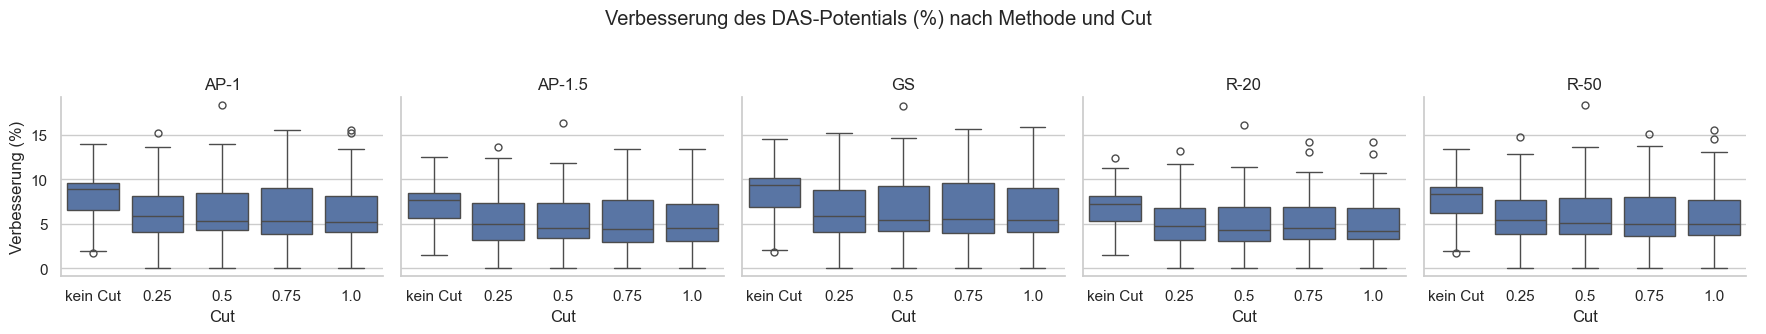

In [8]:
# Verbesserung von Chati an Darstellung -> Abbildung 1

sns.set_style("whitegrid")
cut_order = ["kein Cut", "0.25", "0.5", "0.75", "1.0"]
method_order = ["AP-1", "AP-1.5", "GS", "R-20", "R-50"]

g = sns.catplot(
    data=df_methods,
    x="cut",
    y="MEAN_DAS_potential_percentage",
    col="method_variant",
    kind="box",
    order=cut_order,
    col_order=method_order,
    sharey=True,
    height=3.2,
    aspect=1.1
)
g.set_axis_labels("Cut", "Verbesserung (%)")
g.set_titles("{col_name}")
g.fig.suptitle("Verbesserung des DAS-Potentials (%) nach Methode und Cut", y=1.04)
plt.tight_layout()

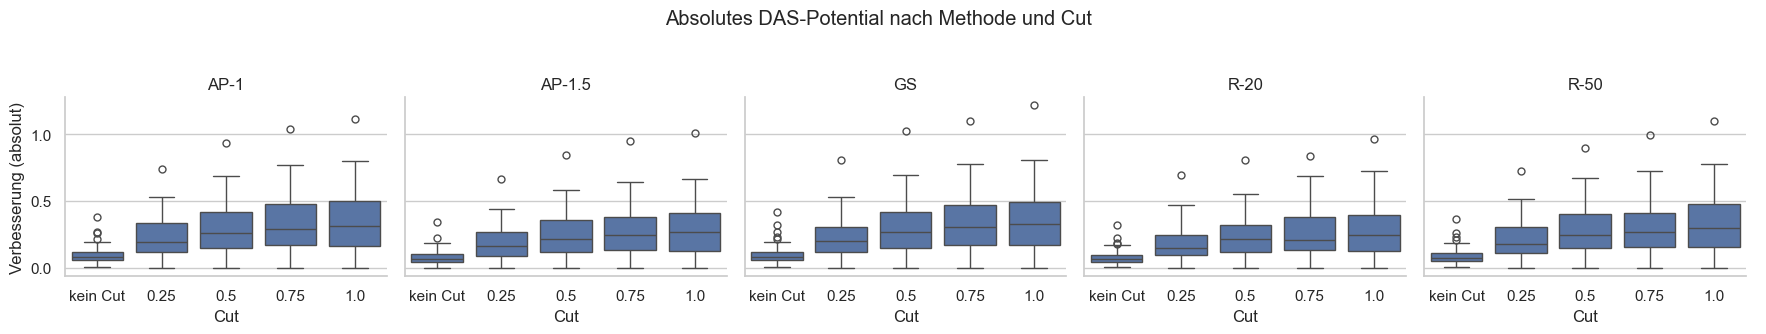

In [9]:
# Verbesserung von Chati an Dartstellung -> Abbildung 2
g2 = sns.catplot(
    data=df_methods,
    x="cut",
    y="MEAN_DAS_potential",
    col="method_variant",
    kind="box",
    order=cut_order,
    col_order=method_order,
    sharey=True,
    height=3.2,
    aspect=1.1
)

g2.set_axis_labels("Cut", "Verbesserung (absolut)")
g2.set_titles("{col_name}")
g2.fig.suptitle("Absolutes DAS-Potential nach Methode und Cut", y=1.04)
plt.tight_layout()

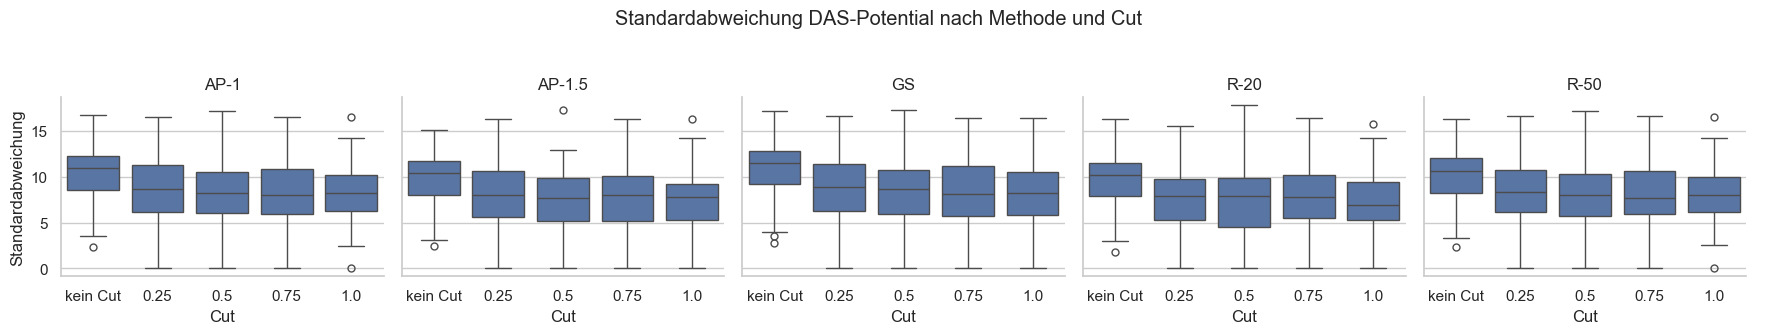

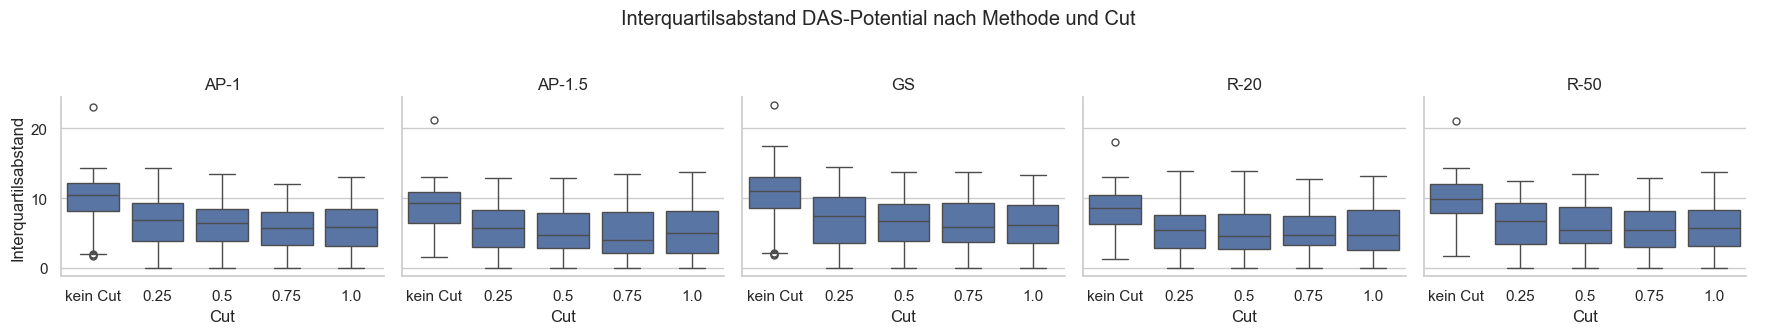

In [10]:
g4 = sns.catplot(
    data=df_methods,
    x="cut",
    y="STD_DAS_potential_percentage",
    col="method_variant",
    kind="box",
    order=cut_order,
    col_order=method_order,
    sharey=True,
    height=3.2,
    aspect=1.1
)

g4.set_axis_labels("Cut", "Standardabweichung")
g4.set_titles("{col_name}")
g4.fig.suptitle("Standardabweichung DAS-Potential nach Methode und Cut", y=1.04)
plt.tight_layout()

g5 = sns.catplot(
    data=df_methods,
    x="cut",
    y="IQR_DAS_potential_percentage",
    col="method_variant",
    kind="box",
    order=cut_order,
    col_order=method_order,
    sharey=True,
    height=3.2,
    aspect=1.1
)

g5.set_axis_labels("Cut", "Interquartilsabstand")
g5.set_titles("{col_name}")
g5.fig.suptitle("Interquartilsabstand DAS-Potential nach Methode und Cut", y=1.04)
plt.tight_layout()

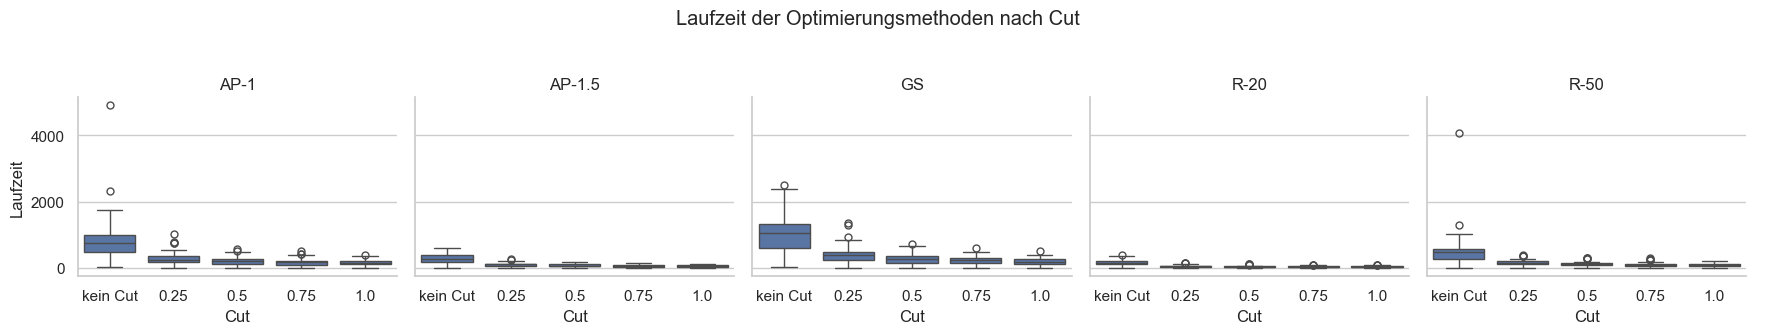

In [11]:
# Verbesserung von Chati an Darstellung -> Abbildung 3
g3 = sns.catplot(
    data=df_methods,
    x="cut",
    y="time",
    col="method_variant",
    kind="box",
    order=cut_order,
    col_order=method_order,
    sharey=True,
    height=3.2,
    aspect=1.1
)

g3.set_axis_labels("Cut", "Laufzeit")
g3.set_titles("{col_name}")
g3.fig.suptitle("Laufzeit der Optimierungsmethoden nach Cut", y=1.04)
plt.tight_layout()


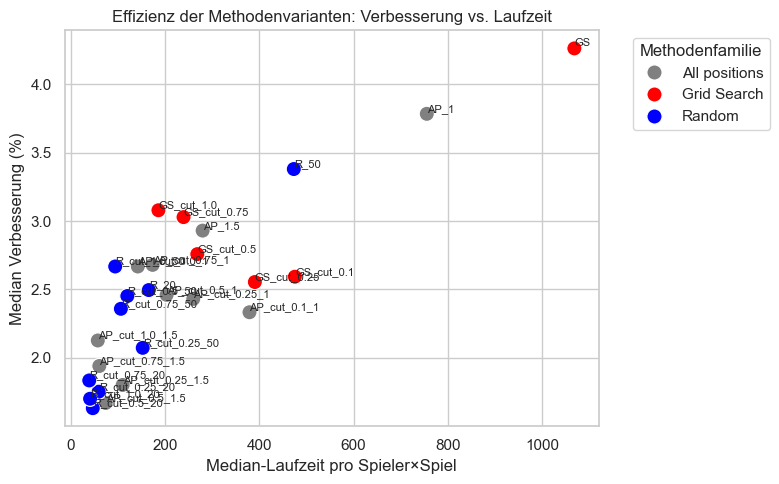

In [12]:
# Verbesserung von Chati an Darstellung -> Abbildung 4
df_agg_scatter = (
    df_methods.groupby(["method_family", "method_variant", "method_short"])
    .agg(
        median_improvement=("MEDIAN_DAS_potential_percentage", "median"),
        median_time=("time", "median")
    )
    .reset_index()
)
palette = {"Grid Search": "red", "Random": "blue", "All positions": "gray"}

fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(
    data=df_agg_scatter,
    x="median_time",
    y="median_improvement",
    hue="method_family",
    s=120,
    ax=ax,
    palette=palette    
)
for _, row in df_agg_scatter.iterrows():
    ax.text(
        row["median_time"],
        row["median_improvement"],
        row["method_short"],
        fontsize=8,
        ha="left",
        va="bottom"
    )

ax.set_xlabel("Median-Laufzeit pro Spieler×Spiel")
ax.set_ylabel("Median Verbesserung (%)")
ax.set_title("Effizienz der Methodenvarianten: Verbesserung vs. Laufzeit")
ax.legend(title="Methodenfamilie", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

'Vergleich Cuts für Grid Search'

'Anzahl verschiedener Parameterkombinationen: 6'

'Vollständige Kombinationen: 40'

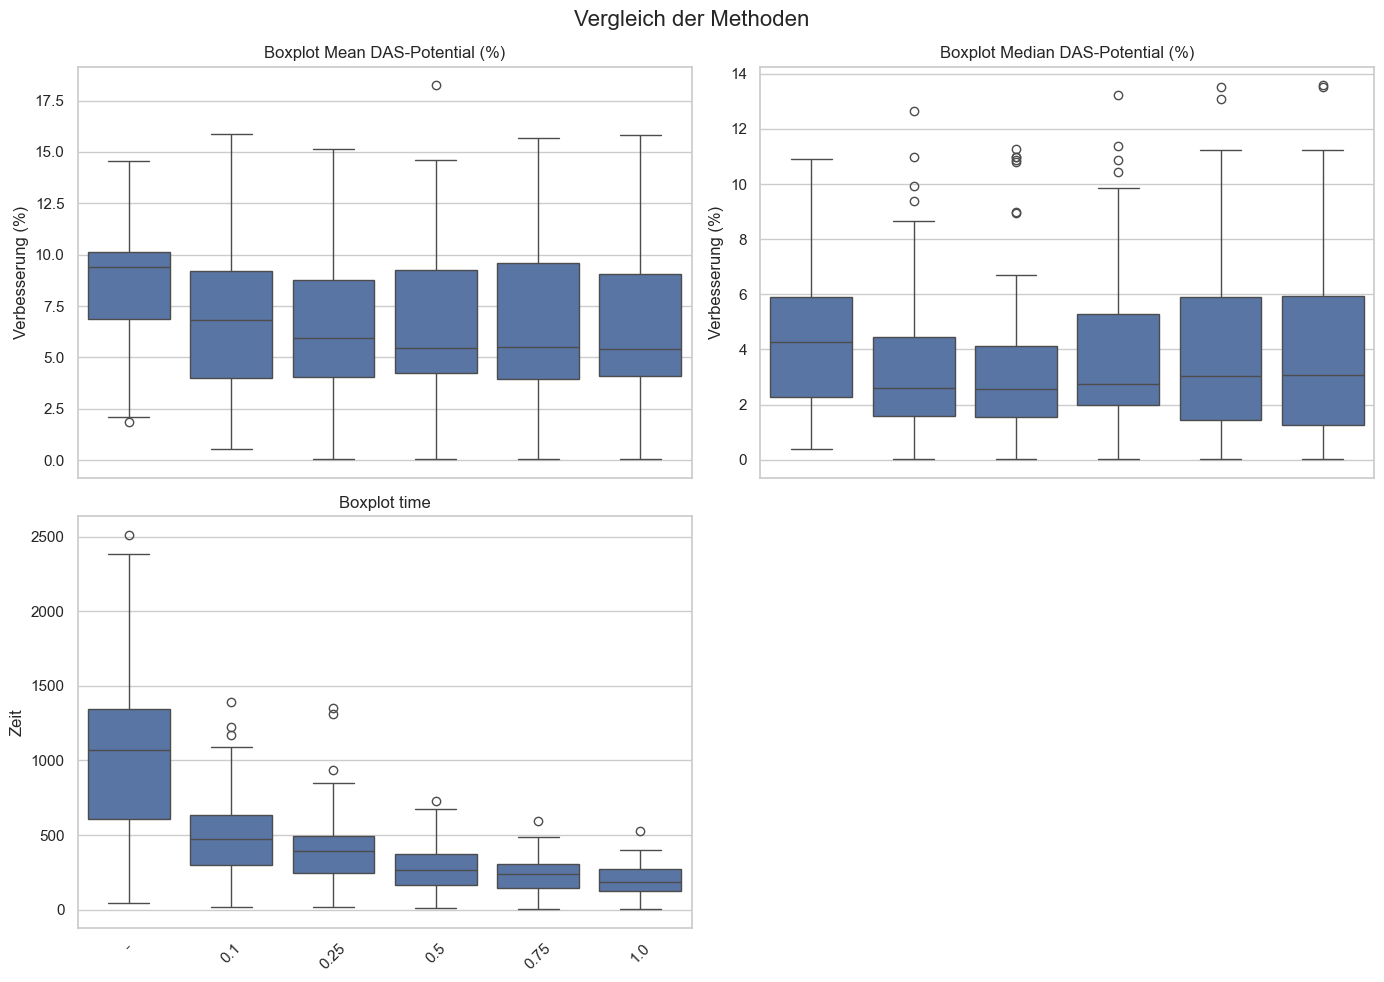

In [13]:
# Vergleich Methoden/Parameter GRID SEARCH => (-, 0.25, 0.5, 1.0) => Aussagekraft relativ gering, da hoher Cut niedrige Werte filtert und Durchschnitt erhöht
df_grid = grouped_df_125[grouped_df_125["method"].str.contains("grid_search")]
df_all = grouped_df_125[grouped_df_125["method"].str.contains("all_positions")]

n_total_params_grid = df_grid["tuning"].nunique()
display("Vergleich Cuts für Grid Search")
display(f"Anzahl verschiedener Parameterkombinationen: {n_total_params_grid}")
param_counts_grid = (
    df_grid.groupby(["game_id", "player_id"])["tuning"]
    .nunique()
    .reset_index(name="param_count")
)
complete_combinations_grid = param_counts_grid[param_counts_grid["param_count"] == n_total_params_grid]
display(f"Vollständige Kombinationen: {len(complete_combinations_grid)}")

fair_grouped_df_grid = df_grid.merge(complete_combinations_grid, on=["game_id", "player_id"])
# display(fair_grouped_df_grid)
compare_methods(fair_grouped_df_grid, x_axis="cut")



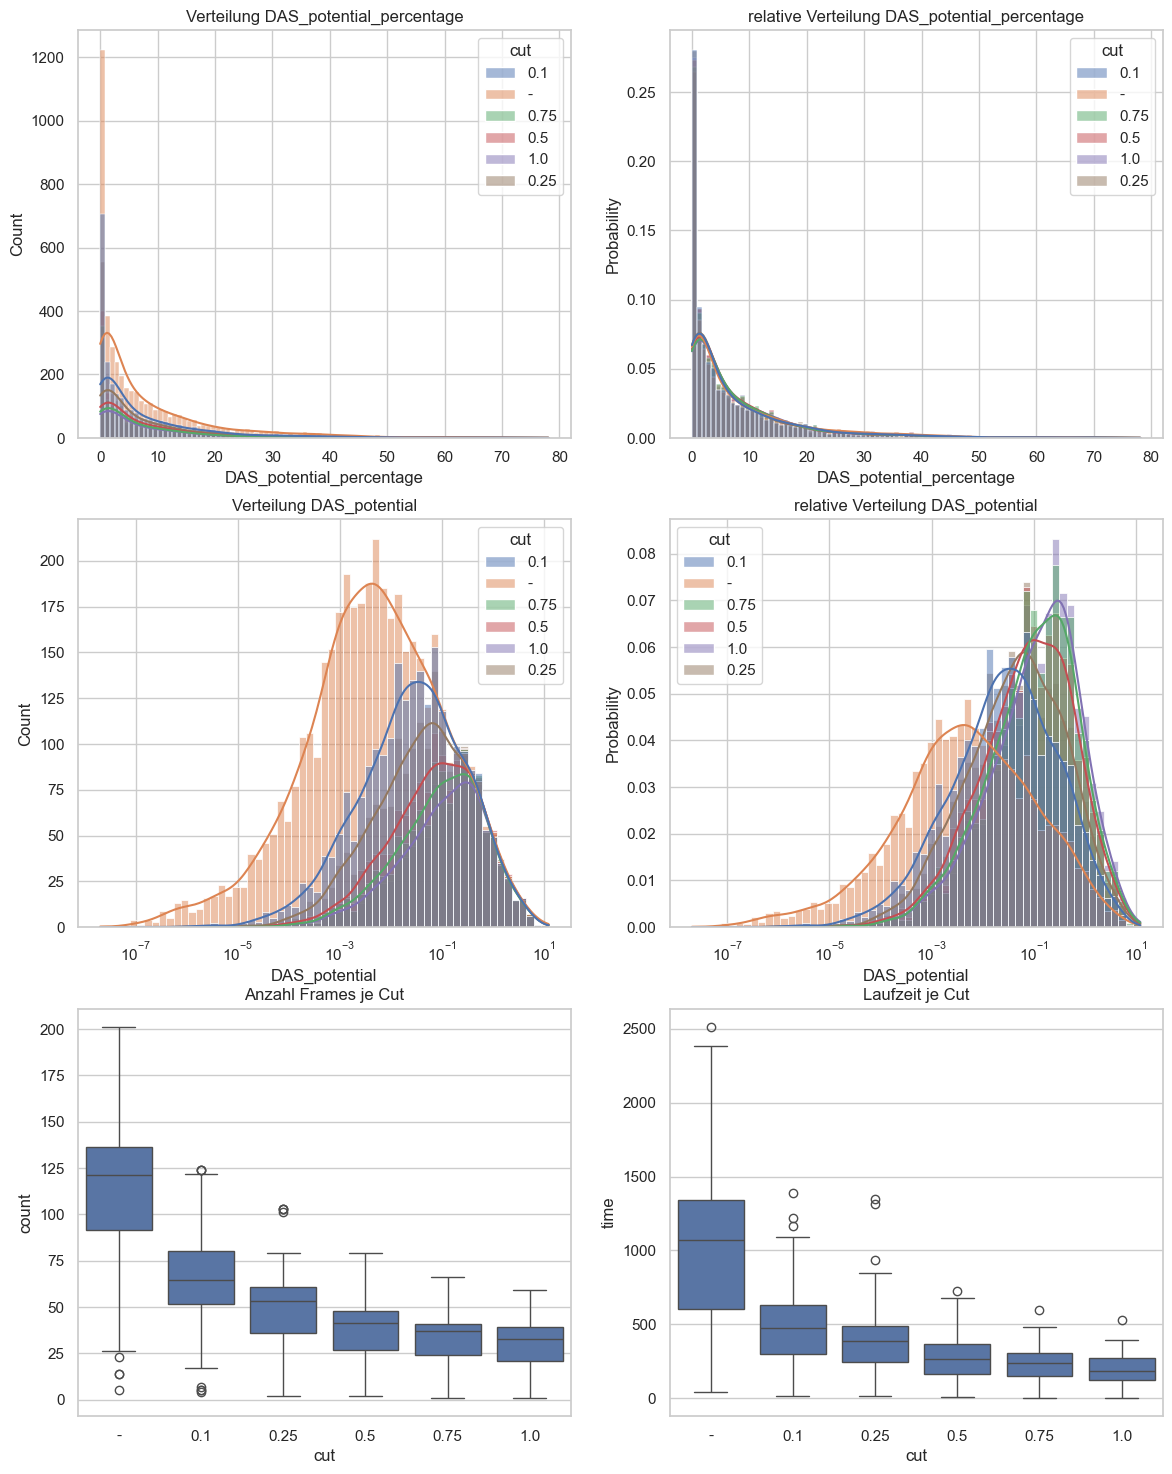

In [14]:
# Vergleich Streuung / Anzahl / Laufzeit GRID SEARCH Cut Zeiten
fig, axes = plt.subplots(3, 2, figsize=(14, 18))

full_df_125 = full_df[full_df["step"] == "step125"].copy()
full_df_125["cut"] = full_df_125["method"].apply(lambda x: x.split("cut_")[-1] if "cut" in x else "-")
full_df_125["method"] = full_df_125["method"].apply(lambda x: x.split("_cut")[0])
full_df_125["n"] = full_df_125["parameters"].apply(lambda x: x.split("N_")[1].split("-")[0])
full_df_125["s"] = full_df_125["parameters"].apply(lambda x: x.split("S_")[1].split("-")[0])
mask_random = full_df_125["method"].str.contains("random")
full_df_125["method"] = np.where(
    mask_random,
    full_df_125["method"] + "_" + full_df_125["n"].astype(pd.Int64Dtype()).astype(str),
    full_df_125["method"],
)
mask_all_positions = full_df_125["method"].str.contains("all_positions")
full_df_125["method"] = np.where(
    mask_all_positions,
    full_df_125["method"] + "_" + full_df_125["s"].astype(str),
    full_df_125["method"]
)
df_full_grid = full_df_125[full_df_125["method"] == "grid_search"].copy()
df_full_grid_non_zero = df_full_grid[df_full_grid["DAS_potential"] > 0]

# Zeile 0
sns.histplot(data=df_full_grid, x="DAS_potential_percentage", hue="cut", kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Verteilung DAS_potential_percentage")

sns.histplot(data=df_full_grid, x="DAS_potential_percentage", hue="cut", kde=True, stat="probability", common_norm=False, ax=axes[0, 1])
axes[0, 1].set_title("relative Verteilung DAS_potential_percentage")

# Zeile 1
sns.histplot(data=df_full_grid_non_zero, x="DAS_potential", hue="cut", log_scale=True, kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Verteilung DAS_potential")

sns.histplot(data=df_full_grid_non_zero, x="DAS_potential", hue="cut", kde=True, stat="probability", common_norm=False, ax=axes[1, 1], log_scale=True)
axes[1, 1].set_title("relative Verteilung DAS_potential")

# Zeile 2
sns.boxplot(data=df_grid, x="cut", y="count", ax=axes[2, 0])
axes[2, 0].set_title("Anzahl Frames je Cut")

sns.boxplot(data=df_grid, x="cut", y="time", ax=axes[2, 1])
axes[2, 1].set_title("Laufzeit je Cut")
plt.show()


/Users/hartmax/Documents/Uni/Masterarbeit/def-accessible-space/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



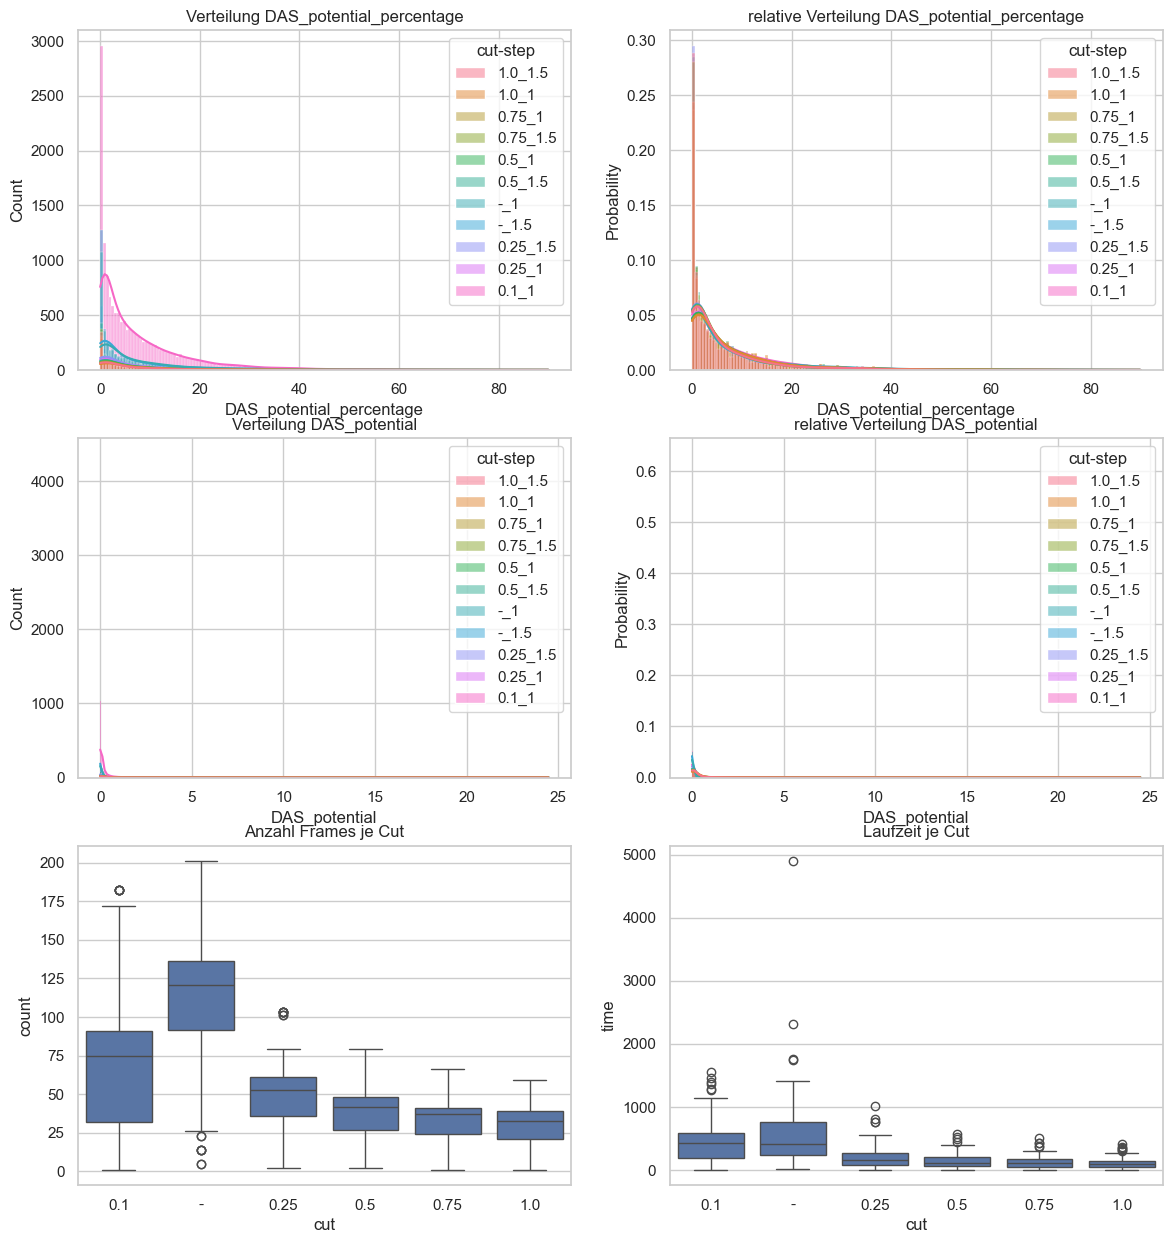

In [15]:
# Vergleich Streuung / Anzahl / Laufzeit ALL_POSITIONS Cut Zeiten
fig, axes = plt.subplots(3, 2, figsize=(14, 15))

df_full_all = full_df_125[full_df_125["method"].str.contains("all_positions")].copy()
df_full_all["cut-step"] = df_full_all["cut"] + "_" + df_full_all["s"]

sns.histplot(data=df_full_all, x="DAS_potential_percentage", hue="cut-step", kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Verteilung DAS_potential_percentage")

sns.histplot(data=df_full_all, x="DAS_potential_percentage", hue="cut-step", kde=True, stat="probability", common_norm=False, ax=axes[0, 1])
axes[0, 1].set_title("relative Verteilung DAS_potential_percentage")

sns.histplot(data=df_full_all, x="DAS_potential", hue="cut-step", kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Verteilung DAS_potential")

sns.histplot(data=df_full_all, x="DAS_potential", hue="cut-step", kde=True, stat="probability", common_norm=False, ax=axes[1, 1])
axes[1, 1].set_title("relative Verteilung DAS_potential")

sns.boxplot(data=df_all, x="cut", y="count", ax=axes[2, 0])
axes[2, 0].set_title("Anzahl Frames je Cut")

sns.boxplot(data=df_all, x="cut", y="time", ax=axes[2, 1])
axes[2, 1].set_title("Laufzeit je Cut")
plt.show()

In [16]:
# Vergleich Streuung / Anzahl / Laufzeit RANDOM Cut Zeiten
full_df_125

,step,game_id,player_id,method,parameters,tuning,frame,new_frame,DAS,DAS_new,DAS_potential,DAS_potential_percentage,move_x,move_y,distance,time_sec,cut,n,s
0,step125,J03WOH,home_19,grid_search,R_5-S_1.5-D_2-N_5-C_0.1,grid_search_cut_0.1-R_5-S_1.5-D_2-N_5-C_0.1,160412,160412_home_19_0.262500_-0.26,0.244021,0.226647,0.017374,7.120028,0.2625,-0.26,0.369468,17.4407,0.1,5,1.5
1,step125,J03WOH,home_19,grid_search,R_5-S_1.5-D_2-N_5-C_0.1,grid_search_cut_0.1-R_5-S_1.5-D_2-N_5-C_0.1,160728,160728_home_19_-0.525000_0.52,0.591525,0.585404,0.006121,1.034811,-0.5250,0.52,0.738935,17.4407,0.1,5,1.5
2,step125,J03WOH,home_19,grid_search,R_5-S_1.5-D_2-N_5-C_0.1,grid_search_cut_0.1-R_5-S_1.5-D_2-N_5-C_0.1,160887,160887_home_19_-1.050000_0.00,1.964608,1.900816,0.063792,3.247053,-1.0500,0.00,1.050000,17.4407,0.1,5,1.5
3,step125,J03WOH,home_19,grid_search,R_5-S_1.5-D_2-N_5-C_0.1,grid_search_cut_0.1-R_5-S_1.5-D_2-N_5-C_0.1,164747,164747_home_19_-1.050000_0.00,0.140323,0.138158,0.002165,1.542877,-1.0500,0.00,1.050000,17.4407,0.1,5,1.5
4,step125,J03WOH,home_19,all_positions_1.5,R_5-S_1.5-D_2-N_20-C_1.0,all_positions_cut_1.0-R_5-S_1.5-D_2-N_20-C_1.0,160887,160887_home_19_-3.50_2.50,1.964608,1.913872,0.050736,2.582484,-3.5000,2.50,4.301163,1.4696,1.0,20,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83547,step125,J03WN1,home_31,all_positions_1,R_5-S_1-D_2-N_20-C_0.1,all_positions_cut_0.1-R_5-S_1-D_2-N_20-C_0.1,155532,155532_home_31_0.00_-5.00,3.132049,2.952712,0.179336,5.725851,0.0000,-5.00,5.000000,123.9913,0.1,20,1
83548,step125,J03WN1,home_31,all_positions_1,R_5-S_1-D_2-N_20-C_0.1,all_positions_cut_0.1-R_5-S_1-D_2-N_20-C_0.1,158123,158123_home_31_-2.00_-4.00,2.387345,2.065800,0.321545,13.468713,-2.0000,-4.00,4.472136,123.9913,0.1,20,1
83549,step125,J03WN1,home_31,all_positions_1,R_5-S_1-D_2-N_20-C_0.1,all_positions_cut_0.1-R_5-S_1-D_2-N_20-C_0.1,166506,166506_home_31_5.00_0.00,0.246944,0.241352,0.005592,2.264450,5.0000,0.00,5.000000,123.9913,0.1,20,1
83550,step125,J03WN1,home_31,all_positions_1,R_5-S_1-D_2-N_20-C_0.1,all_positions_cut_0.1-R_5-S_1-D_2-N_20-C_0.1,168445,168445_home_31_0.00_-5.00,0.367376,0.363733,0.003643,0.991750,0.0000,-5.00,5.000000,123.9913,0.1,20,1


## Vergleich letzte Entscheidung

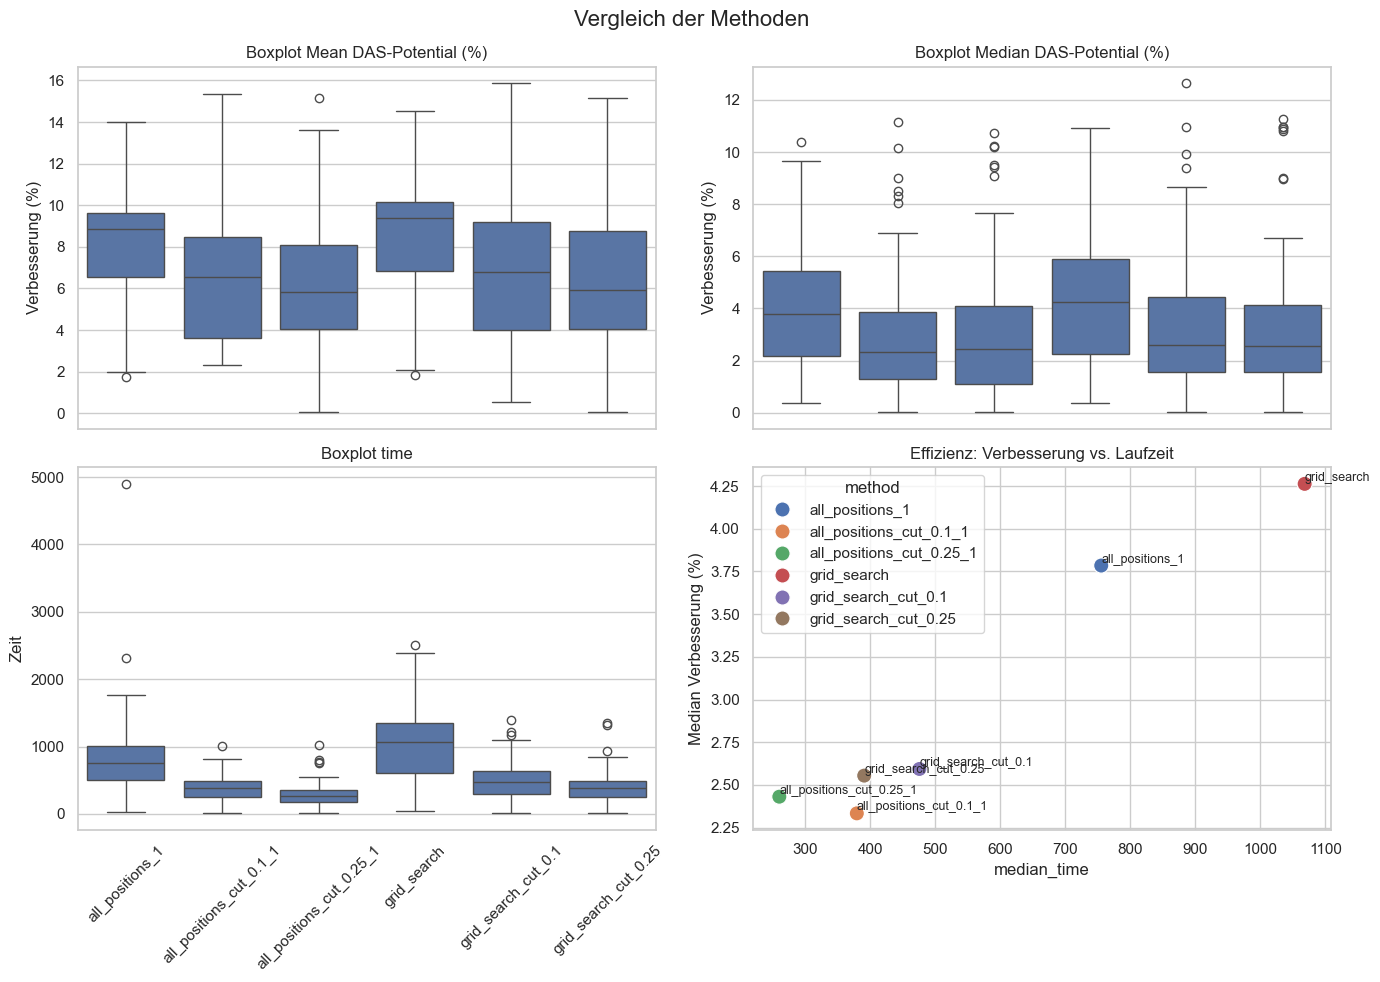

In [17]:
COMPARE_METHODS = [
    "all_positions_1", "all_positions_cut_0.1_1", "all_positions_cut_0.25_1",
    "grid_search", "grid_search_cut_0.1", "grid_search_cut_0.25"
]

df_decision = df_methods.copy()
df_decision = df_decision[df_decision["method"].isin(COMPARE_METHODS)]

n_total_params = df_decision["tuning"].nunique()
param_counts = (
    df_decision.groupby(["game_id", "player_id"])["tuning"]
    .nunique()
    .reset_index(name="param_count")
)
complete_combinations = param_counts[param_counts["param_count"] == n_total_params]
fair_grouped_decision = df_decision.merge(complete_combinations, on=["game_id", "player_id"])

df_agg_scatter = (
    fair_grouped_decision.groupby("method").agg(
        median_improvement_pct=("MEDIAN_DAS_potential_percentage", "median"),
        median_time=("time", "median")
    )
    .reset_index()
)
compare_methods(fair_grouped_decision, df_agg_scatter)

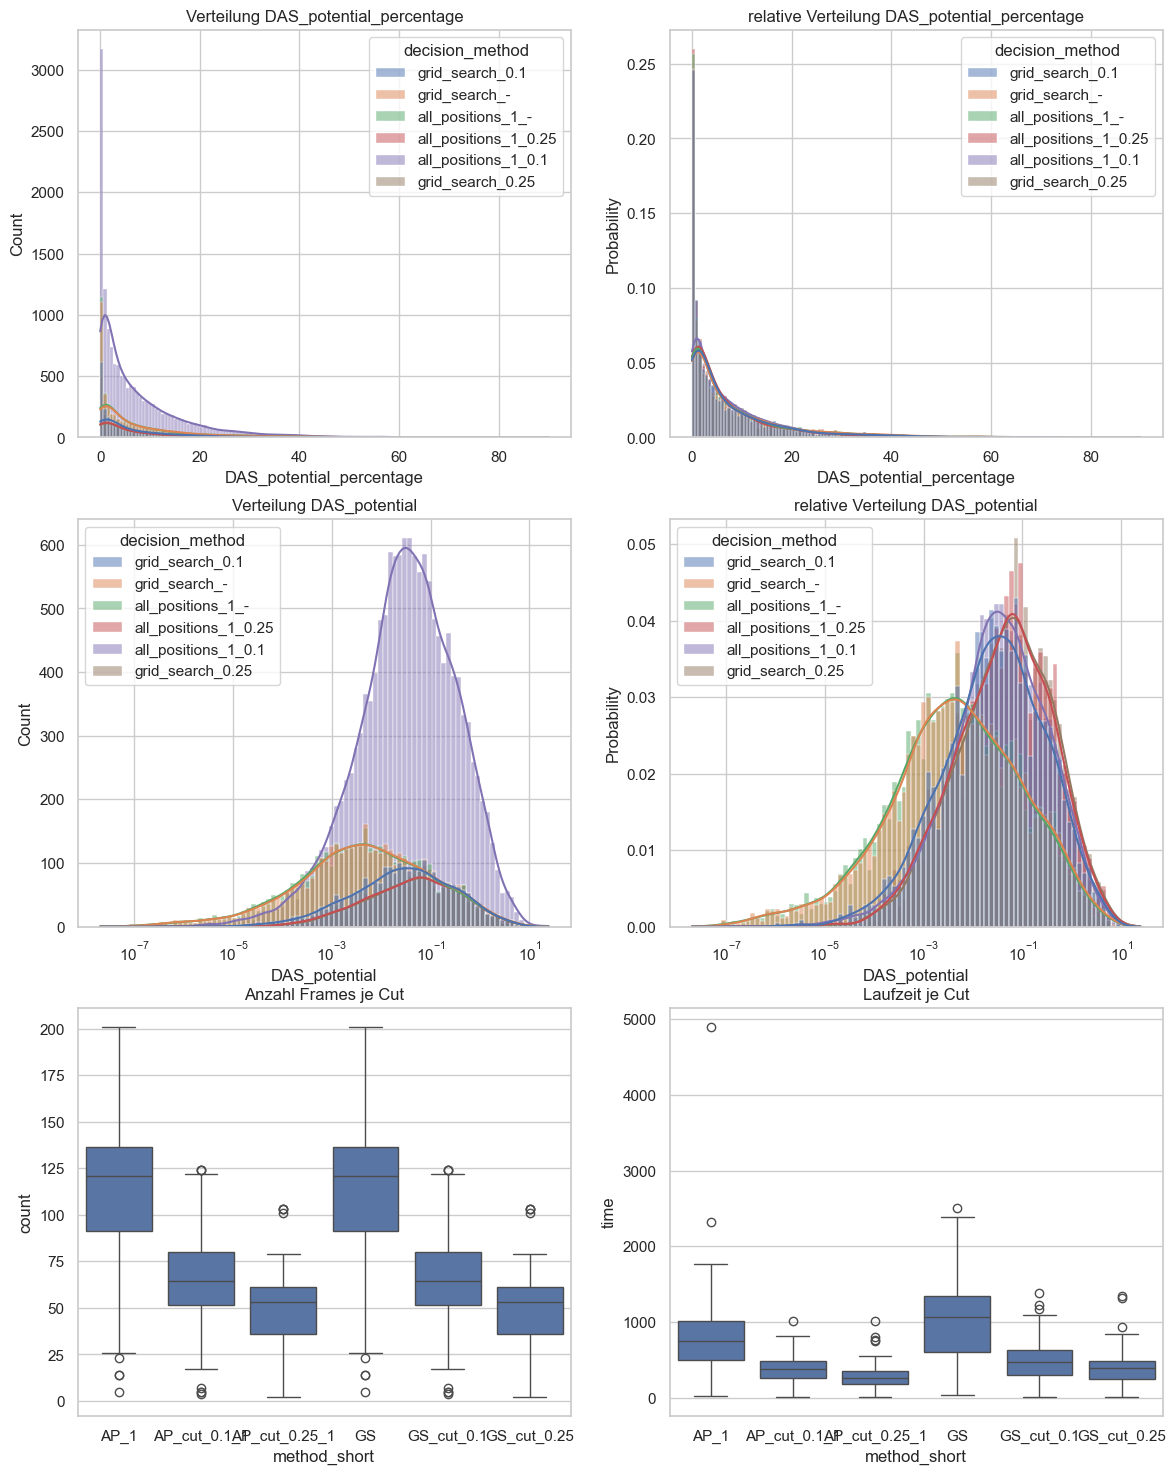

In [18]:
FULL_COMPARE_METHODS = [
    "grid_search_0.1", "grid_search_-", "grid_search_0.25",
    "all_positions_1_-", "all_positions_1_0.1", "all_positions_1_0.25"
]

df_full_decision = full_df_125.copy()
df_full_decision["decision_method"] = df_full_decision["method"] + "_" + df_full_decision["cut"]

df_full_decision = df_full_decision[df_full_decision["decision_method"].isin(FULL_COMPARE_METHODS)]

df_full_decision_non_zero = df_full_decision[df_full_decision["DAS_potential"] > 0]


fig, axes = plt.subplots(3, 2, figsize=(14, 18))

sns.histplot(data=df_full_decision, x="DAS_potential_percentage", hue="decision_method", kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Verteilung DAS_potential_percentage")

sns.histplot(data=df_full_decision, x="DAS_potential_percentage", hue="decision_method", kde=True, stat="probability", common_norm=False, ax=axes[0, 1])
axes[0, 1].set_title("relative Verteilung DAS_potential_percentage")

# Zeile 1
sns.histplot(data=df_full_decision_non_zero, x="DAS_potential", hue="decision_method", log_scale=True, kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Verteilung DAS_potential")

sns.histplot(data=df_full_decision_non_zero, x="DAS_potential", hue="decision_method", kde=True, stat="probability", common_norm=False, ax=axes[1, 1], log_scale=True)
axes[1, 1].set_title("relative Verteilung DAS_potential")

# Zeile 2
sns.boxplot(data=df_decision, x="method_short", y="count", ax=axes[2, 0])
axes[2, 0].set_title("Anzahl Frames je Cut")

sns.boxplot(data=df_decision, x="method_short", y="time", ax=axes[2, 1])
axes[2, 1].set_title("Laufzeit je Cut")
plt.show()

## Archiv

In [21]:
# Archiv: Spieler für alle Spiele
n_total_games = grouped_df_125["game_id"].nunique()
print(f"Anzahl Spiele: {n_total_games}")

all_players = add_player_names()
grouped_named = grouped_df_125.merge(all_players, on=["game_id", "player"], how="left")

games_played = grouped_named.groupby("id")["game_id"].nunique().reset_index(name="games_played")
n_max_games = games_played["games_played"].max()
all_game_players = games_played[games_played["games_played"] == min(n_max_games, n_total_games)]

fair_grouped_df = grouped_named.merge(all_game_players, on="id")

line_players(fair_grouped_df)
line_players(fair_grouped_df, metric="DAS_potential_percentage_over1")
line_players(fair_grouped_df, metric="DAS_potential_over1")

Anzahl Spiele: 5


KeyError: 'player'

In [ ]:
# Vergleich Cut-Werte / No Cut Step 125

from pandas import pivot_table


df_cut_auswertung = full_df.copy()
df_cut_auswertung = df_cut_auswertung[df_cut_auswertung["step"] == "step125"]
tail = df_cut_auswertung["parameters"].astype(str).str.split("_").str[4].str.split("-").str[0]
mask = df_cut_auswertung["method"].str.contains("random")

df_cut_auswertung["method"] = np.where(
    mask,
    df_cut_auswertung["method"] + "_" + tail,
    df_cut_auswertung["method"]
)
df_cut_auswertung["cut"] = df_cut_auswertung["method"].apply(
    lambda x: x.split("cut_")[-1].split("_")[0] if "cut" in x else 0
)
display(df_cut_auswertung["cut"].unique())
# Vergleich Anzahl berücksichtigter Frames -> Unabhängig von Methode
df_cut_auswertung_count = (
    df_cut_auswertung.groupby(["game_id", "player_id", "method", "cut"])["frame"].count().reset_index()
)
df_cut_auswertung_count = (
    df_cut_auswertung_count.groupby(["game_id", "player_id", "cut"]).agg(
        max_frames=("frame", "max"),
        min_frames=("frame", "min")
    ).reset_index()
)
df_cut_auswertung_count["diff_frames"] = df_cut_auswertung_count["max_frames"] - df_cut_auswertung_count["min_frames"]

# Nur zum checken -> Keine Fehler gefunden
# mistakes = df_cut_auswertung_count[df_cut_auswertung_count["diff_frames"] > 0]
# mistakes
pivot_counts = pivot_table(
    df_cut_auswertung_count,
    values="max_frames",
    index=["game_id", "player_id"],
    columns="cut",
    aggfunc="max",
).dropna().reset_index()
num_cols = pivot_counts.select_dtypes(include="number").columns
pivot_counts[num_cols] = pivot_counts[num_cols].astype("int64")
pivot_counts



array([0, '0.5', '1.0', '0.25', '0.75'], dtype=object)

cut,game_id,player_id,0,0.25,0.5,0.75,1.0
0,J03WQQ,home_25,201,103,79,66,59


# Darstellung Thesis



##### Kapitel 3.6 -> Vergleich Random - All

In [19]:
relevant_methods = ["all_positions_1", "random_20", "random_50"]
temp_df = fair_grouped_df[fair_grouped_df["method"].isin(relevant_methods)]
temp_agg = (
    temp_df.groupby("method").agg(
        sumDAS=("SUMME_DAS_original", "sum"),
        sumPotential=("SUMME_DAS_potential", "sum"),
        sumTime=("time", "sum"),
        sumCount=("count", "sum"),
        count=("count", "count"),
        medianPotential=("SUMME_DAS_potential", "median"),
        meanPotential=("SUMME_DAS_potential", "mean")
    )
    .reset_index()
)
temp_agg["meanPotentialIndirect"] = temp_agg["sumPotential"] / temp_agg["sumCount"]
temp_agg["meanPotentialPercentage"] = temp_agg["sumPotential"] / temp_agg["sumDAS"] * 100
temp_agg["meanTime"] = temp_agg["sumTime"] / temp_agg["count"]
# compare_methods(temp_df, temp_agg)
temp_agg

,method,sumDAS,sumPotential,sumTime,sumCount,count,medianPotential,meanPotential,meanPotentialIndirect,meanPotentialPercentage,meanTime
0,all_positions_1,7373.970509,508.131321,35825.7080,4475,40,9.583750,12.703283,0.113549,6.890878,895.642700
1,random_20,7373.970509,418.797757,6767.7730,4475,40,7.756669,10.469944,0.093586,5.679406,169.194325
2,random_50,7373.970509,484.094304,21956.7165,4475,40,9.177580,12.102358,0.108177,6.564907,548.917912


##### Kapitel 3.6 -> Vergleich Grid Search - All

In [20]:
relevant_methods = ["all_positions_1", "grid_search", "random_50"]
temp_df = fair_grouped_df[fair_grouped_df["method"].isin(relevant_methods)]
temp_agg = (
    temp_df.groupby("method").agg(
        sumDAS=("SUMME_DAS_original", "sum"),
        sumPotential=("SUMME_DAS_potential", "sum"),
        sumTime=("time", "sum"),
        sumCount=("count", "sum"),
        count=("count", "count"),
        medianPotential=("SUMME_DAS_potential", "median"),
        meanPotential=("SUMME_DAS_potential", "mean")
    )
    .reset_index()
)
temp_agg["meanPotentialIndirect"] = temp_agg["sumPotential"] / temp_agg["sumCount"]
temp_agg["meanPotentialPercentage"] = temp_agg["sumPotential"] / temp_agg["sumDAS"] * 100
temp_agg["meanTime"] = temp_agg["sumTime"] / temp_agg["count"]
# compare_methods(temp_df, temp_agg)
temp_agg

,method,sumDAS,sumPotential,sumTime,sumCount,count,medianPotential,meanPotential,meanPotentialIndirect,meanPotentialPercentage,meanTime
0,all_positions_1,7373.970509,508.131321,35825.7080,4475,40,9.583750,12.703283,0.113549,6.890878,895.642700
1,grid_search,7373.970509,540.051056,40609.9965,4475,40,10.654514,13.501276,0.120682,7.323749,1015.249913
2,random_50,7373.970509,484.094304,21956.7165,4475,40,9.177580,12.102358,0.108177,6.564907,548.917912
